# 02671 Fourier Neural Operator for Burgers' equation in 1D
s194322, s193181



## Load packages

In [295]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import torch
import torch.nn as nn

from IPython.display import HTML
import matplotlib.animation


# Burger's equation
Consider the PDE problem
$$u_t + \frac{1}{2} (u^2)_x = \epsilon u_{xx}, \quad -1 < x < 1, \quad t > 0,$$
$$u(x,0) = \eta(x), \quad -1 \leq x \leq 1.$$
Assume that the diffusion coefficient is a constant, $\epsilon > 0$.
Setup the problem with an initial condition, $\eta(x) = - \sin(\pi x)$ and $\epsilon = 0.01/\pi$.
In this project we will solve the problem numerically (using a Fourier method), by a neural network and by using neural operators. We will analyse and compare the different methods and solutions.

## Numerical solution

In [296]:
# Solve the ODE using fft
def rhsBurgers(u, t, kappa, epsilon):
    uhat = fft(u)
    duhat = (1j)*kappa*uhat
    dduhat = -np.power(kappa,2)*uhat
    du = ifft(duhat)
    ddu = ifft(dduhat)
    dudt = -u*du + epsilon*ddu
    return dudt.real

def plot_solution(u,x,t):
    # Plot the solution
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    img = ax[0].imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto', origin='upper')
    plt.colorbar(img, ax=ax[0])
    ax[0].set_title('Numerical solution')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('t')
    ax[0].invert_yaxis()  # Invert the y-axis

    # Plot in 3d
    X, T = np.meshgrid(x, t)
    ax[1] = fig.add_subplot(122, projection='3d')
    ax[1].plot_surface(X, T, u, cmap='viridis')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('t')
    ax[1].set_zlabel('u')
    ax[1].set_title('Numerical solution')
    plt.show()

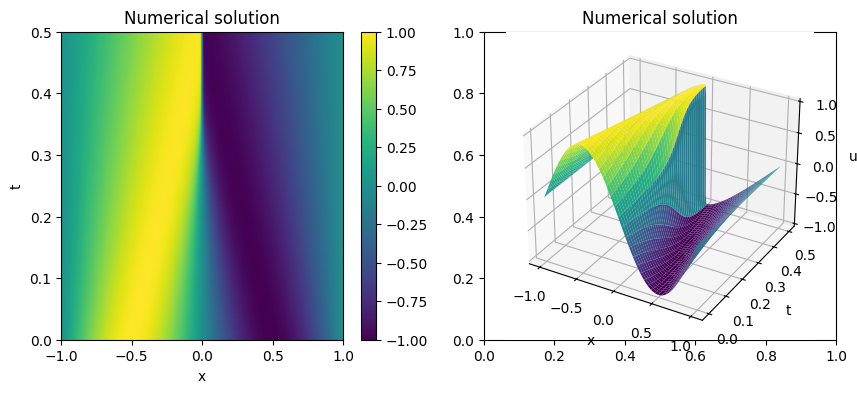

In [297]:
N = 256+1
x = np.linspace(-1,1, N)
tend = 1/2
t = np.linspace(0, tend, N)

dx = x[1] - x[0]

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

# Initial condition
u0 = -np.sin(np.pi*x)

u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# Plot the solution
plot_solution(u,x,t)


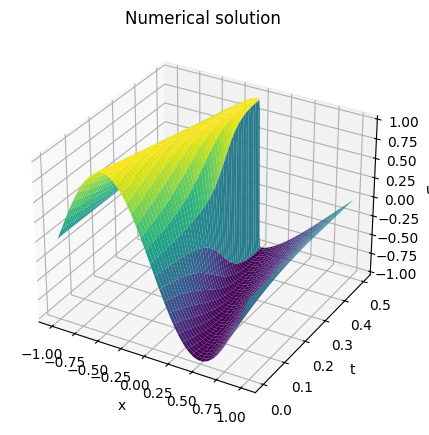

In [298]:
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.set_title('Numerical solution')
plt.show()


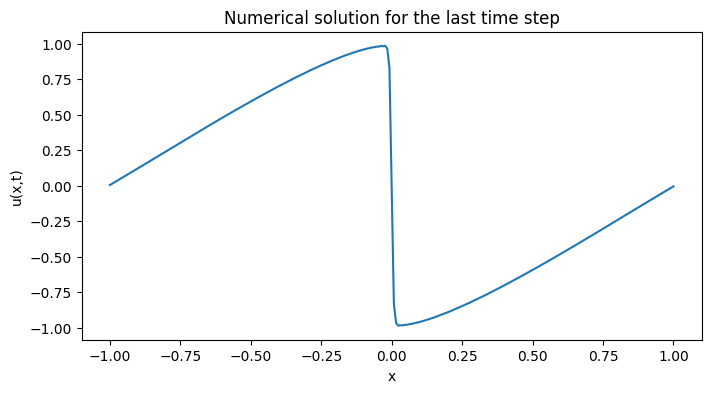

In [299]:
u_snapshot = u[-1,:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, u_snapshot)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Numerical solution for the last time step')
plt.show()


### New inital condition

We solve the PDE numerically with the new inital conditions, that is:
$$u_1 (x) = -2 \sin (\pi x), \\ u_2 (x) = -\cos (\pi x) .$$

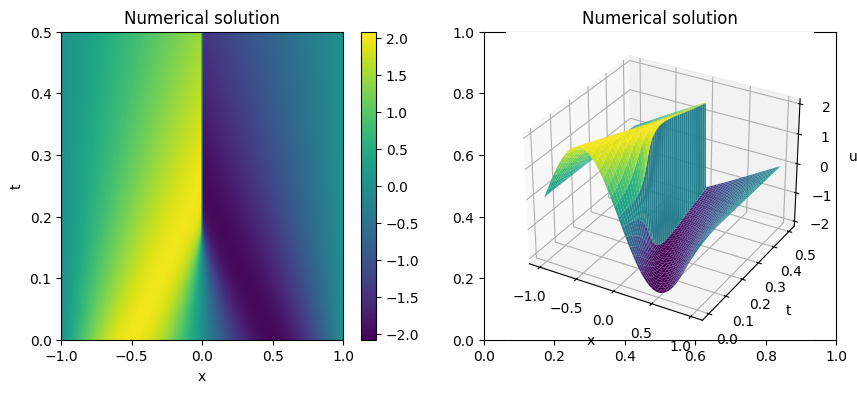

In [300]:
# New initial condition
u1 = -2*np.sin(np.pi*x)

u = odeint(rhsBurgers, u1, t, args=(kappa,epsilon))

# Plot the solution
plot_solution(u,x,t)


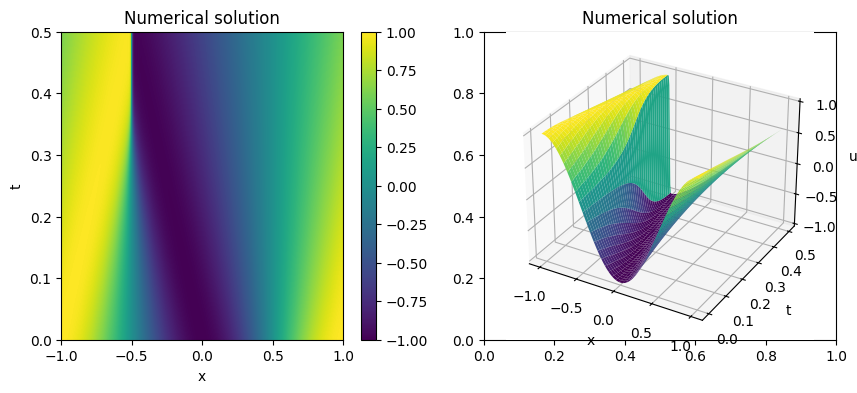

In [301]:
# New initial condition
u2 = -np.cos(np.pi*x)

u = odeint(rhsBurgers, u2, t, args=(kappa,epsilon))

# Plot the solution
plot_solution(u,x,t)


## Solve Burgers' equation using NN
We will now solve the PDE using a neural network.

### Define models

In [302]:
# Function to train the FNN model
def model_NN(p, u0, x, t, kappa, epsilon, epochs):
    # p = percentage of data to use for training

    u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

    # Split the data into training and testing sets
    n_train = int(p * u.shape[0])

    u_train = u[:n_train, :]
    u_test = u[n_train:, :]

    X, T = np.meshgrid(x, t)

    # Split X and T into training and testing sets
    X_train = X[:n_train, :]
    X_test = X[n_train:, :]
    T_train = T[:n_train, :]
    T_test = T[n_train:, :]

    # Define the FNN model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(u.shape[1]))  # Output layer with the same shape as u
    learning_rate = 0.01  # Adjust this value as needed
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(np.hstack((X_train, T_train)), u_train, epochs=epochs, batch_size=32, validation_split=0.2)

    # Evaluate the model on the testing data
    loss = model.evaluate(np.hstack((X_test, T_test)), u_test)
    print("Test Loss:", loss)

    # Make predictions
    predictions = model.predict(np.hstack((X, T)))

    return u, predictions


We now define the model that trains on the provided initial condition and predicts on a new initial condition.


In [303]:
def model_NN_new_IC(p, u0, x, t, kappa, epsilon, u0_predict):
    # Solve PDE for the given initial condition
    u = odeint(rhsBurgers, u0, t, args=(kappa, epsilon))

    # Split the data into training and testing sets
    n_train = int(p * u.shape[0])
    u_train = u[:n_train, :]
    u_test = u[n_train:, :]

    X, T = np.meshgrid(x, t)

    # Split X and T into training and testing sets
    X_train = X[:n_train, :]
    X_test = X[n_train:, :]
    T_train = T[:n_train, :]
    T_test = T[n_train:, :]

    # Define the FNN model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(u.shape[1]))  # Output layer with the same shape as u
    learning_rate = 0.01  # Adjust this value as needed
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(np.hstack((X_train, T_train)), u_train, epochs=100, batch_size=32, validation_split=0.2)

    # Evaluate the model on the testing data
    loss = model.evaluate(np.hstack((X_test, T_test)), u_test)
    print("Test Loss:", loss)

    # Make predictions on the testing data
    predictions = model.predict(np.hstack((X, T)))

    # Make predictions on the provided initial condition u0_predict
    u_predict = odeint(rhsBurgers, u0_predict, t, args=(kappa, epsilon))
    X_predict, T_predict = np.meshgrid(x, t)
    predictions_new_IC = model.predict(np.hstack((X_predict, T_predict)))

    return u, predictions, u_predict, predictions_new_IC


Function to plot the predictions.

In [304]:
def plot_prediction(x,t,predictions,u,save=False):
    
    X, T = np.meshgrid(x, t)

    # Plot u predicted in 3D
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X,T,predictions, cmap='viridis')
    ax1.set_title('u predicted')
    ax1.set_xlabel('X')
    ax1.set_ylabel('T')
    ax1.set_zlabel('Value')

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X,T,u, cmap='viridis')
    ax2.set_title('u true')
    ax2.set_xlabel('X')
    ax2.set_ylabel('T')
    ax2.set_zlabel('Value')

    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X,T,np.abs(predictions-u), cmap='viridis')
    ax3.set_title('Difference')
    ax3.set_xlabel('X')
    ax3.set_ylabel('T')
    ax3.set_zlabel('Value')

    # Save figure
    if save:
        plt.savefig('figs/burgers_NN.png')

    plt.show()

We use the model to make predictions for the three different initial conditions.

### Initial condition: $u_0(x) = - \sin (\pi x)$

In [305]:
# Define percentage of data to use for training
P = 0.8
N = 256+1
epochs = 100

# Define the initial condition
u0 = -np.sin(np.pi*x)
u0_1 = -2*np.sin(np.pi*x)
u0_2 = -np.cos(np.pi*x)

x = np.linspace(-1,1, N)
tend = 1/2
t = np.linspace(0, tend, N)

# Define constants
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

u, predictions = model_NN(P, u0, x, t, kappa, epsilon,epochs)

# Plot the prediction
plot_prediction(x,t,predictions,u,save=False)


/home/vscode/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.3878 - val_loss: 0.1253
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0366 - val_loss: 0.0641
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 - val_loss: 0.0569
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - val_loss: 0.0485
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0410
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 0.0379
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - val_loss: 0.0311
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0200
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0142
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2896e-04 - val_loss: 

### Calculate error in the different time steps

RMSE for the first model: 0.072216


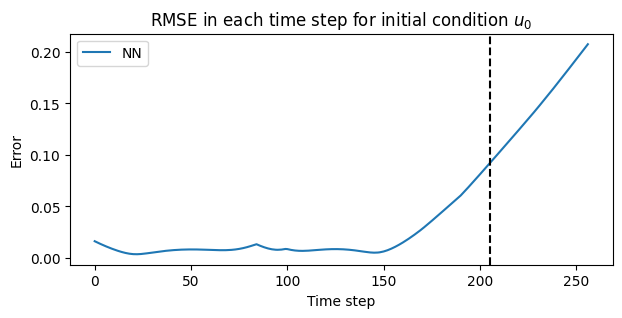

In [306]:
# Calculate RMSE
def RMSE(predictions, u):
    return np.sqrt(np.mean((predictions - u)**2))

# Calculate the RMSE for the first model
rmse1 = RMSE(predictions, u)
print(f'RMSE for the first model: {rmse1:.5}')

# Plot error
error_NN = []
n_train = int(P * u.shape[0])

for i in range(N):
    error_NN.append(RMSE(u[i], predictions[i]))

plt.figure(figsize=(7,3))
plt.plot(error_NN, label ='NN')
plt.title('RMSE in each time step for initial condition $u_0$')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
#plt.savefig('figs/error.png')
plt.show()


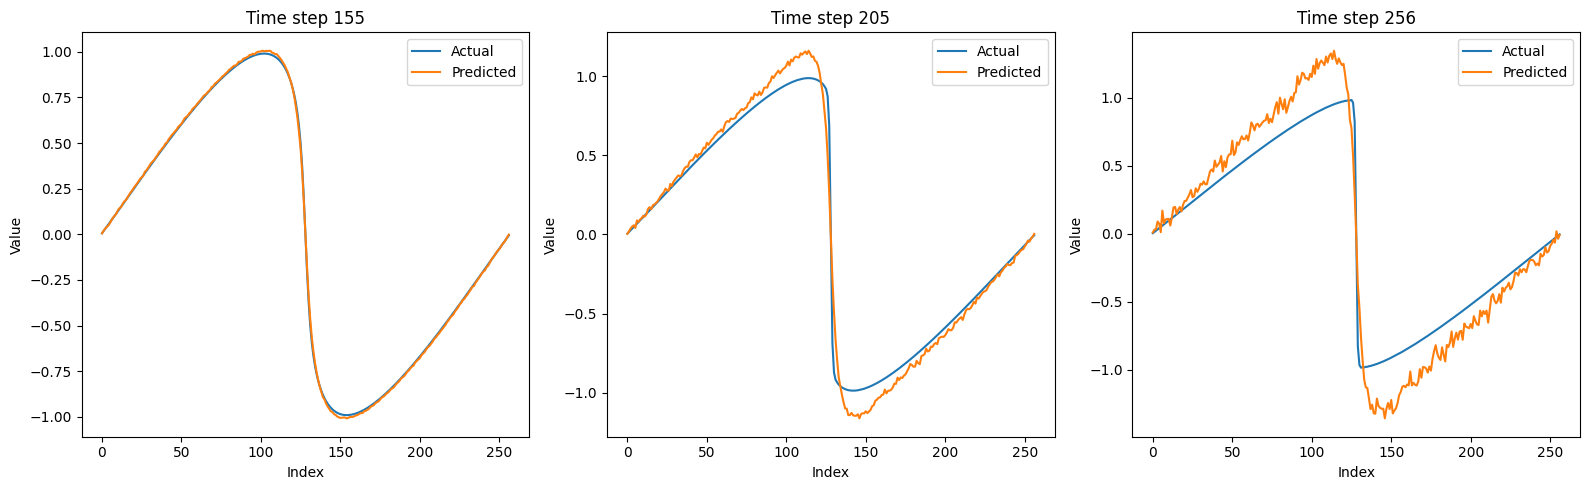

In [307]:
# Define the indices for the plots
indices = [155, 205, 256]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(u[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

# Save the figure
plt.tight_layout()
#plt.savefig('figs/subplots.png')
plt.show()


### New initial condition: $u_0(x) = -2 \sin ( \pi x)$

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.3800 - val_loss: 0.0791
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.0567
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221 - val_loss: 0.0398
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - val_loss: 0.0495
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.0303
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - val_loss: 0.0356
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0181
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_loss: 0.0241
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0131
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0112
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1055e-04 - val_loss: 0

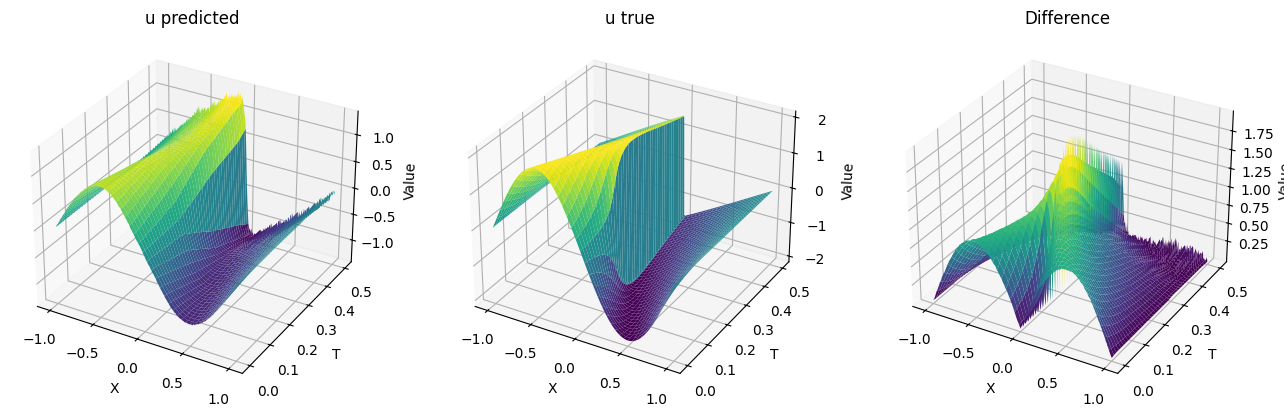

In [308]:
# Define percentage of data to use for training
P = 0.8
N = 256+1
epochs = 100

# Define the initial condition
u0 = -np.sin(np.pi*x)
u0_new = -2*np.sin(np.pi*x)

x = np.linspace(-1,1, N)
tend = 1/2
t = np.linspace(0, tend, N)

# Define constants
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

u, predictions, u_predict, predictions_new_IC = model_NN_new_IC(P, u0, x, t, kappa, epsilon, u0_new)

# Plot the prediction
plot_prediction(x,t,predictions_new_IC,u_predict,save=False)

In [309]:
# Compute error
print(f'RMSE= {RMSE(predictions_new_IC,u_predict):.4}')

# Plot error
error = []
n_train = int(P * u.shape[0])

for i in range(N):
    error.append(RMSE(u_predict[i], predictions_new_IC[i]))

plt.figure(figsize=(7,3))
plt.plot(error, label ='NN')
plt.title('RMSE in each time step for initial condition $u_0$')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
#plt.savefig('figs/error.png')
plt.show()


RMSE= 0.5837


### New inital condition: $u_0(x) = - \cos (\pi x) $ 

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3839 - val_loss: 0.0724
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0322 - val_loss: 0.0829
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - val_loss: 0.0724
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - val_loss: 0.0392
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0354
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0170
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0149
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0131
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0084
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7055e-04 - val_loss: 

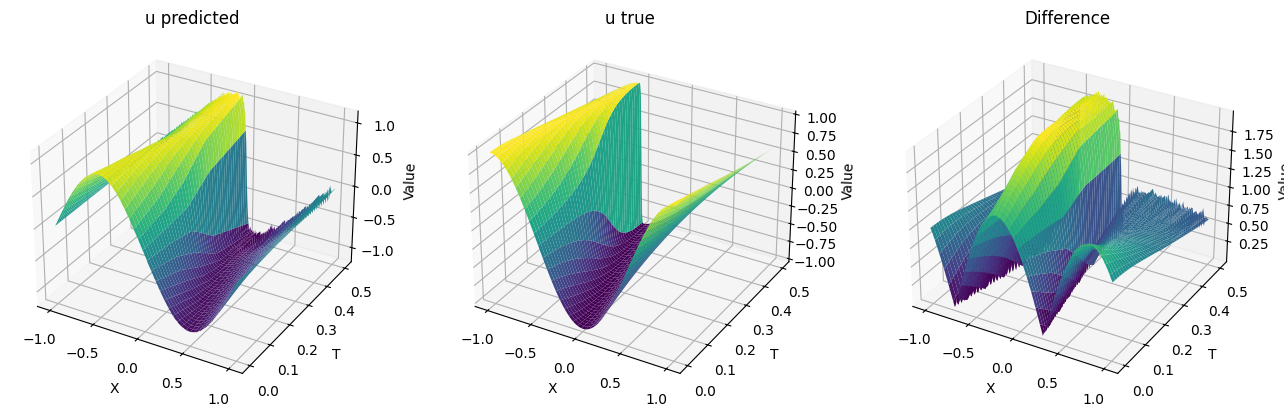

In [310]:
# Define percentage of data to use for training
P = 0.8
N = 256+1
epochs = 100

# Define the initial condition
u0 = -np.sin(np.pi*x)
u0_new = -np.cos(np.pi*x)

x = np.linspace(-1,1, N)
tend = 1/2
t = np.linspace(0, tend, N)

# Define constants
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

u, predictions, u_predict, predictions_new_IC = model_NN_new_IC(P, u0, x, t, kappa, epsilon, u0_new)

# Plot the prediction
plot_prediction(x,t,predictions_new_IC,u_predict,save=False)

RMSE= 1.024


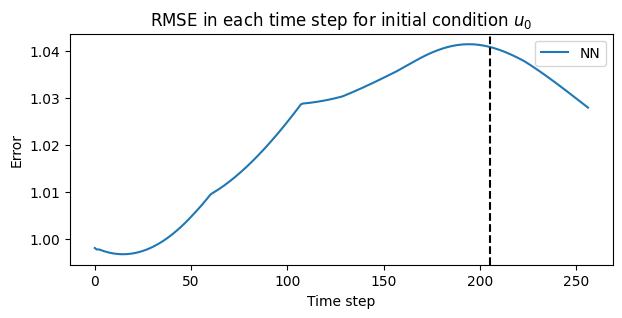

In [311]:
# Compute error
print(f'RMSE= {RMSE(predictions_new_IC,u_predict):.4}')

# Plot error
error = []
n_train = int(P * u.shape[0])

for i in range(N):
    error.append(RMSE(u_predict[i], predictions_new_IC[i]))

plt.figure(figsize=(7,3))
plt.plot(error, label ='NN')
plt.title('RMSE in each time step for initial condition $u_0$')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
#plt.savefig('figs/error.png')
plt.show()

## Solve Burgers' equation using FNO
We will solve the PDE using a Fourier Neural Operator.

### Define network

In [312]:
class SpectralConv2d(nn.Module):
    def __init__(self,
                 in_channels,   # Number of input channels
                 out_channels,  # Number of output channels
                 modes1,        # Number of Fourier modes to multiply in the first dimension
                 modes2):       # Number of Fourier modes to multiply in the second dimension
        super(SpectralConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

Function to prepare data.

In [313]:
def prep_data_from_u(x_train__):

    N1,N2 = x_train__.shape

    x_org = np.reshape(x_train__, (N1, N2, 1))
    x_org = np.transpose(x_org, (2, 0, 1))
    x_org = np.float32(x_org)

    y_train = np.zeros_like(x_org)
    y_train = np.float32(y_train)
    y_train= x_org[:, 1:, :]

    x_train = np.zeros_like(x_org)
    x_train = x_org[:, :-1, :]

    m1,m2,m3 = x_train.shape  

    x_train = np.reshape(x_train, (m2, 1, m3))
    y_train = np.reshape(y_train, (m2, 1, m3))

    #add channel dimension
    x_train = np.expand_dims(x_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)

    x_train = np.reshape(x_train, (m2, 1, m3,1))
    y_train = np.reshape(y_train, (m2, 1, m3,1))

    return x_train, y_train,x_org

### Multi-step prediction for inital condition $u_0(x)$

In [314]:
N = 256+1
x = np.linspace(-1,1, N)

tend = 1
N2 = 150 
t = np.linspace(0, tend, N2)

dx = x[1] - x[0]

# Initial condition
u0 = -np.sin(np.pi*x)

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

train_portion = 0.8
N_train = int(train_portion*N2)
x_train__ = u[:N_train,:]
x_test__ = u[N_train:,:]

#Split x and t as well
t_train = t[:N_train]
t_test = t[N_train:]

# Assuming your data is stored in a tensor called 'data'
data = torch.tensor(x_train__ ) 

# Reshape the data into sequential samples of 10 consecutive time instances
num_time_instances = data.shape[0]
num_input_channels = 10

# Calculate the number of sequential samples
num_samples = num_time_instances - num_input_channels + 1
y_train_reshaped = data[num_input_channels - 1:]

# Reshape the data into (num_samples, num_input_channels, num_features)
reshaped_data = torch.zeros(num_samples, num_input_channels, data.shape[1])

for i in range(num_samples):
    reshaped_data[i] = data[i:i+num_input_channels]

#put an extra dimension on the reshaped data
reshaped_data = reshaped_data.unsqueeze(1)
y_train_reshaped = y_train_reshaped.unsqueeze(1)
y_train_reshaped = y_train_reshaped.unsqueeze(1)


#reshape the 1 -dimension to be the last
reshaped_data = reshaped_data.permute(0,2,3, 1)
y_train_reshaped = y_train_reshaped.permute(0,2,3, 1)

#train the model
x_train = reshaped_data
y_train = y_train_reshaped

x_train = x_train.float()
y_train = y_train.float()

In [315]:
model = SpectralConv2d(10, 1, 250, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 3000
for epoch in range(n_epochs):
    # Run the forward pass
    y_pred = model(x_train)

    # Calculate the loss
    loss = criterion(y_pred, y_train)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

y_pred = model(x_train)

Epoch 0, Loss: 0.10634658485651016
Epoch 50, Loss: 0.00411971565335989
Epoch 100, Loss: 0.0005350959254428744
Epoch 150, Loss: 0.0005190680385567248
Epoch 200, Loss: 0.0005106424214318395
Epoch 250, Loss: 0.0005012414767406881
Epoch 300, Loss: 0.0004909886629320681
Epoch 350, Loss: 0.00048001634422689676
Epoch 400, Loss: 0.00046843840391375124
Epoch 450, Loss: 0.0004563545517157763
Epoch 500, Loss: 0.0004438539035618305
Epoch 550, Loss: 0.00043101696064695716
Epoch 600, Loss: 0.0004179173265583813
Epoch 650, Loss: 0.00040462243487127125
Epoch 700, Loss: 0.0003911942185368389
Epoch 750, Loss: 0.0003776898083742708
Epoch 800, Loss: 0.0003641619114205241
Epoch 850, Loss: 0.000350658519892022
Epoch 900, Loss: 0.00033722404623404145
Epoch 950, Loss: 0.00032389917760156095
Epoch 1000, Loss: 0.0003107206430286169
Epoch 1050, Loss: 0.00029772205743938684
Epoch 1100, Loss: 0.00028493368881754577
Epoch 1150, Loss: 0.00027238274924457073
Epoch 1200, Loss: 0.00026009356952272356
Epoch 1250, Loss: 

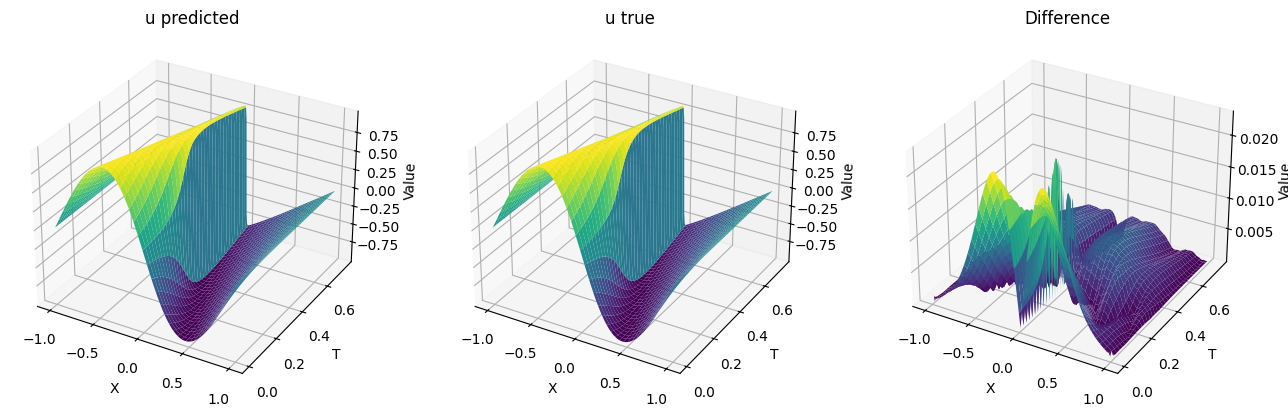

In [316]:
#make plot of the results inner domain
y_pred = model(x_train)

y_train__ = y_train.squeeze().detach().numpy()
y_pred = y_pred.squeeze().detach().numpy()

#use the plot_prediction function to plot the results
plot_prediction(x,t_train[1:len(y_pred)+1],y_pred,y_train__,save=False)


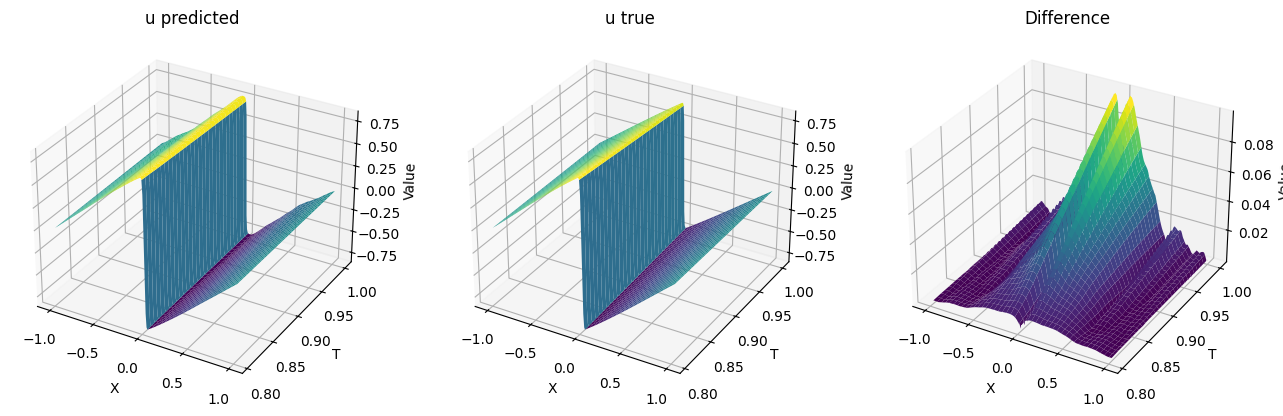

In [317]:
x_train_val = x_train[-1:]

y_pred_val = model(x_train_val)
predictions = []

for i in range(len(x_test__)):
    # Predict using the model
    y_pred_val = model(x_train_val)

    # Replace the last element of the second dimension with y_pred_val
    #x_train_val_2 = torch.zeros_like(x_train_val)
    x_train_val[:, 0, :, :] = x_train_val[:, 1, :, :]
    x_train_val[:, 1, :, :] = x_train_val[:, 2, :, :]
    x_train_val[:, 2, :, :] = x_train_val[:, 3, :, :]
    x_train_val[:, 3, :, :] = x_train_val[:, 4, :, :]
    x_train_val[:, 4, :, :] = x_train_val[:, 5, :, :]
    x_train_val[:, 5, :, :] = x_train_val[:, 6, :, :]
    x_train_val[:, 6, :, :] = x_train_val[:, 7, :, :]
    x_train_val[:, 7, :, :] = x_train_val[:, 8, :, :]
    x_train_val[:, 8, :, :] = x_train_val[:, 9, :, :]
    x_train_val[:, 9, :, :] = y_pred_val

    # Save the prediction
    prediction_array = y_pred_val.squeeze().detach().numpy()
    predictions.append(prediction_array)

##show the results:
plot_prediction(x,t_test,np.array(predictions),x_test__,save=False)


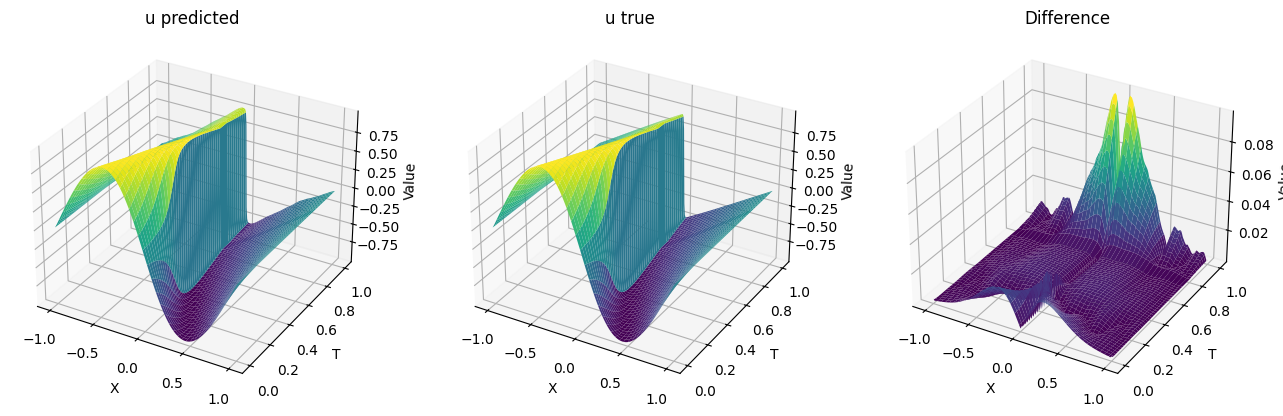

In [318]:
#concate y_pred with predictions
predictions = np.array(predictions)


#they have the size (30, 257) and (111, 257), concatenate along the first axis
predictions_concat = np.concatenate((y_pred, predictions), axis=0)


#concate t_test and t_train
t_concat = np.concatenate((t_train[:len(t_train)-9], t_test), axis=0)
true_label_concat =  u[9:,:]


plot_prediction(x,t_concat,np.array(predictions_concat),true_label_concat,save=False)

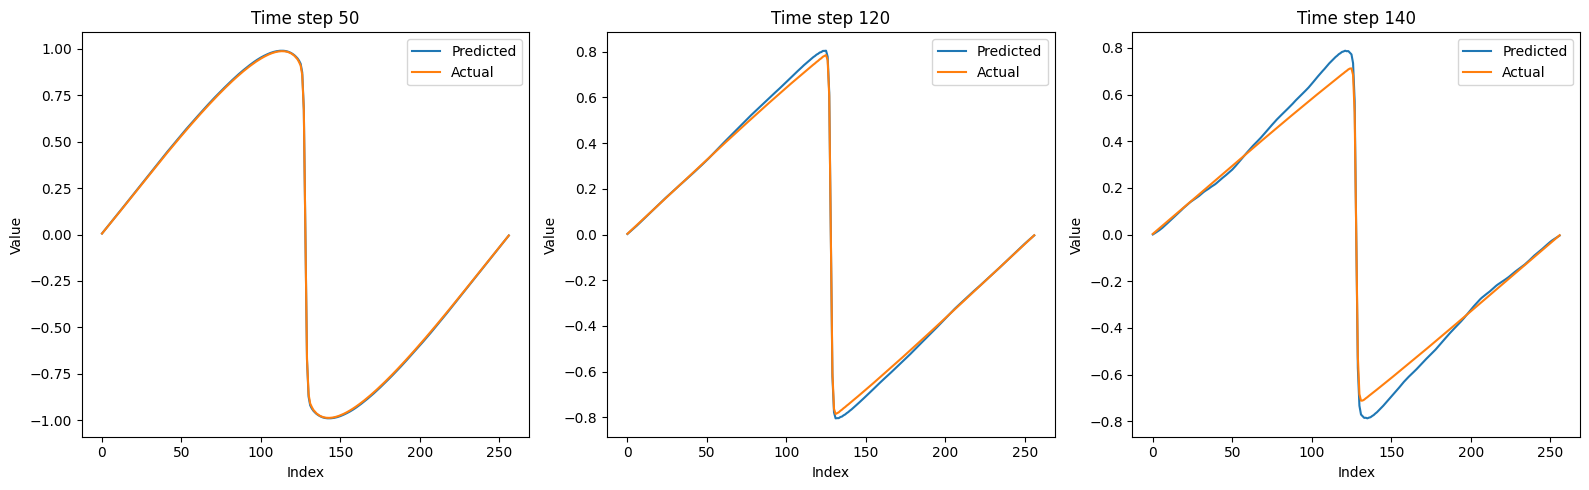

In [319]:
# Concatenate y_pred and predictions
pred_concat = np.concatenate((y_pred, np.array(predictions)))
u_concat = np.concatenate((y_train__,x_test__))

# Define the indices for the plots
indices = [50,120,140]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(pred_concat[index], label='Predicted')
    ax.plot(u_concat[index], label='Actual')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

# Save the figure
plt.tight_layout()
plt.show()


### Initial condition $u_0(x) = - \sin (\pi x) $

In [320]:
N = 256+1
tend = 1/2
t = np.linspace(0, tend, N)
x = np.linspace(-1,1, N)

# Initial condition
u0 = -np.sin(np.pi*x)

#split u into train and test data
train_portion = 0.8
N_train = int(train_portion*N)
N2_train = int(train_portion*N2)

u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

x_train__ = u[:N_train,:]
x_test__ = u[N_train:,:]

#Split x and t as well
t_train = t[:N2_train]
t_test = t[N2_train:]

x_train,y_train,x_org = prep_data_from_u(x_train__)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

# Define the neural network
#train the model
model = SpectralConv2d(1, 1, 200, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 3000
for epoch in range(n_epochs):
    # Run the forward pass
    y_pred = model(x_train)

    # Calculate the loss
    loss = criterion(y_pred, y_train)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Make predictions
y_pred = model(x_train)

Epoch 0, Loss: 0.22592943906784058
Epoch 100, Loss: 0.16290074586868286
Epoch 200, Loss: 0.11628037691116333
Epoch 300, Loss: 0.08095718920230865
Epoch 400, Loss: 0.05474269017577171
Epoch 500, Loss: 0.0358213447034359
Epoch 600, Loss: 0.02261005900800228
Epoch 700, Loss: 0.013724902644753456
Epoch 800, Loss: 0.007989791221916676
Epoch 900, Loss: 0.0044488925486803055
Epoch 1000, Loss: 0.002363971434533596
Epoch 1100, Loss: 0.0011963594006374478
Epoch 1200, Loss: 0.0005758673651143909
Epoch 1300, Loss: 0.0002636081480886787
Epoch 1400, Loss: 0.00011506630835356191
Epoch 1500, Loss: 4.8367503040935844e-05
Epoch 1600, Loss: 2.013099947362207e-05
Epoch 1700, Loss: 8.867968972481322e-06
Epoch 1800, Loss: 4.634604920283891e-06
Epoch 1900, Loss: 3.132957544949022e-06
Epoch 2000, Loss: 2.6284801606379915e-06
Epoch 2100, Loss: 2.4669604954397073e-06
Epoch 2200, Loss: 2.4170026335923467e-06
Epoch 2300, Loss: 2.401766550974571e-06
Epoch 2400, Loss: 2.396980789853842e-06
Epoch 2500, Loss: 2.39530

### Visualize prediction

In [321]:
# prepare data
x_all__ = u

t_all = t

x_all,y_all,x_org = prep_data_from_u(x_all__)

x_all = torch.tensor(x_all)
y_all = torch.tensor(y_all)

# Make predictions
y_pred = model(x_all)

#reshape it to only keep two dimensions
y_pred = np.squeeze(y_pred)
y_all= np.squeeze(y_all)

#make the tensors to numpy
y_all_ = y_all.detach().numpy()
y_pred_ = y_pred.detach().numpy()

plot_prediction(x,t_all[1:],y_pred_,y_all_,save=False)

### Calculate error in the different time steps

In [322]:
# Calculate RMSE
def RMSE(predictions, u):
    return np.sqrt(np.mean((predictions - u)**2))

# Calculate the RMSE for the model
rmse1 = RMSE(y_pred_ ,y_all_)
print(f'RMSE= {rmse1:.5}')

y_all.shape

RMSE= 0.0020204


torch.Size([256, 257])

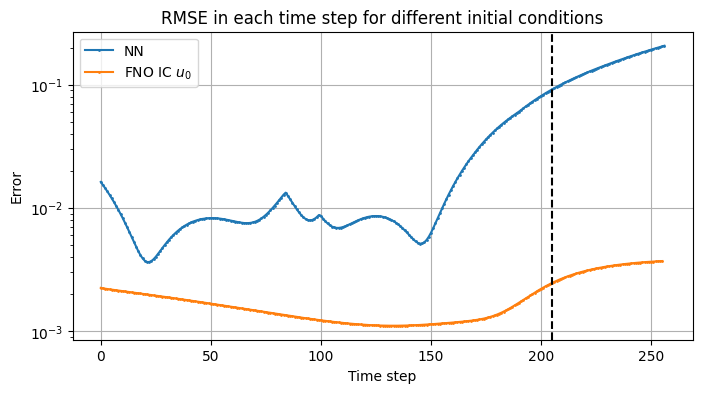

In [323]:
# Add to error plot
error_FNO = []

n_train = int(P * u.shape[0])

for i in range(N-1):
    error_FNO.append(RMSE(y_all_[i], y_pred_[i]))


plt.figure(figsize=(8,4))

plt.semilogy(error_NN,'.-', label='NN', markersize=2)
plt.semilogy(error_FNO,'.-', label ='FNO IC $u_0$',markersize=2)
plt.title('RMSE in each time step for different initial conditions')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
plt.grid(True)
#plt.savefig('figs/error.png')
plt.show()

### New initial condition: $u_0(x) = -2 \sin ( \pi x)$

RMSE= 0.0082695


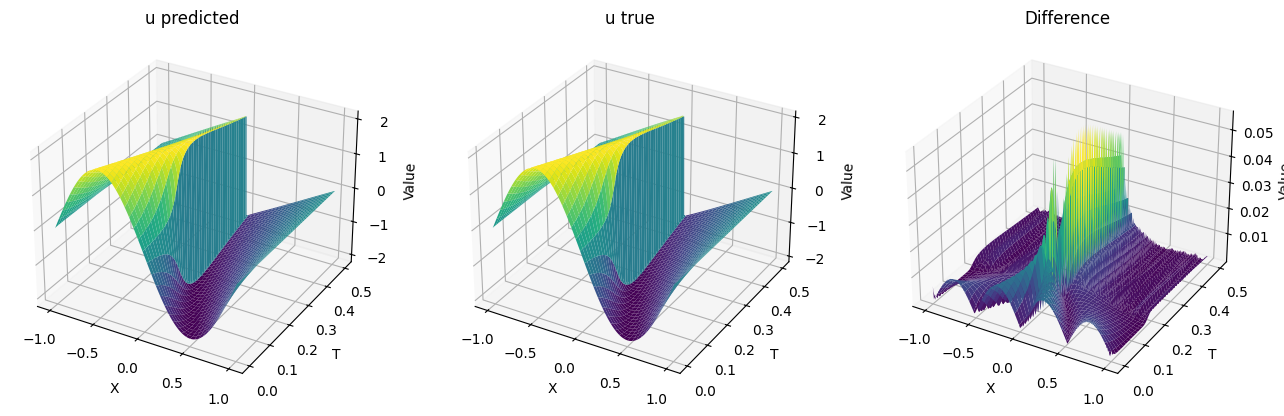

In [324]:
# Initial condition
u0 = -2*np.sin(np.pi*x)
u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# prepare data
x_all__ = u

t_all = t

x_all,y_all,x_org = prep_data_from_u(x_all__)

x_all = torch.tensor(x_all)
y_all = torch.tensor(y_all)

# Make predictions
y_pred = model(x_all)

#reshape it to only keep two dimensions
y_pred = np.squeeze(y_pred)
y_all= np.squeeze(y_all)

#make the tensors to numpy
y_all_ = y_all.detach().numpy()
y_pred_ = y_pred.detach().numpy()

# Calculate the RMSE for the model
rmse1 = RMSE(y_pred_ ,y_all_)
print(f'RMSE= {rmse1:.5}')

plot_prediction(x,t_all[1:],y_pred_,y_all_,save=False)

In [325]:
# Add to error plot
error_FNO_u1 = []

n_train = int(P * u.shape[0])

for i in range(N-1):
    error_FNO_u1.append(RMSE(y_all_[i], y_pred_[i]))


plt.figure(figsize=(8,4))
#plt.plot(error_NN,'.', label='NN')
#plt.plot(error_FNO,'.', label ='FNO IC $u_0$')
plt.semilogy(error_NN,'.-', label='NN', markersize=2)
plt.semilogy(error_FNO,'.-', label ='FNO IC $u_0$',markersize=2)
plt.semilogy(error_FNO_u1,'.-', label ='FNO IC $u_1$',markersize=2)
plt.title('RMSE in each time step for different initial conditions')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
plt.grid(True)
#plt.savefig('figs/error.png')
plt.show()

### New initial condition: $u_0(x) = - \cos ( \pi x)$

In [326]:
# Initial condition
u0 = -np.cos(np.pi*x)
u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# prepare data
x_all__ = u

t_all = t

x_all,y_all,x_org = prep_data_from_u(x_all__)

x_all = torch.tensor(x_all)
y_all = torch.tensor(y_all)

# Make predictions
y_pred = model(x_all)

#reshape it to only keep two dimensions
y_pred = np.squeeze(y_pred)
y_all= np.squeeze(y_all)

#make the tensors to numpy
y_all_ = y_all.detach().numpy()
y_pred_ = y_pred.detach().numpy()

# Calculate the RMSE for the model
rmse1 = RMSE(y_pred_ ,y_all_)
print(f'RMSE= {rmse1:.5}')

plot_prediction(x,t_all[1:],y_pred_,y_all_,save=False)

RMSE= 0.0024063


In [327]:
# Add to error plot
error_FNO_u2 = []

n_train = int(P * u.shape[0])

for i in range(N-1):
    error_FNO_u2.append(RMSE(y_all_[i], y_pred_[i]))


plt.figure(figsize=(8,4))

plt.semilogy(error_NN,'.-', label='NN', markersize=2)
plt.semilogy(error_FNO,'.-', label ='FNO IC $u_0$',markersize=2)
plt.semilogy(error_FNO_u1,'.-', label ='FNO IC $u_1$',markersize=2)
plt.semilogy(error_FNO_u2,'.-', label ='FNO IC $u_2$',markersize=2)

plt.title('RMSE in each time step for different initial conditions')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
plt.grid(True)
#plt.savefig('figs/error.png')
plt.show()

### Error for all methods

In [328]:
# Plot error
plt.figure(figsize=(8,4))

plt.semilogy(error_NN,'.-', label='NN', markersize=2)
plt.semilogy(error_FNO,'.-', label ='FNO IC $u_0$',markersize=2)
plt.semilogy(error_FNO_u1,'.-', label ='FNO IC $u_1$',markersize=2)
plt.semilogy(error_FNO_u2,'.-', label ='FNO IC $u_2$',markersize=2)

plt.title('RMSE in each time step for different initial conditions')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.axvline(x=n_train, color='k', linestyle='--')  
plt.legend()
plt.grid(True)
plt.savefig('figs/error.png')
plt.show()

## Create animation and QR code

In [329]:
# Define percentage of data to use for training
P = 0.8
N = 256+1
epochs = 100

# Define the initial condition
u0 = -np.sin(np.pi*x)
u0_1 = -2*np.sin(np.pi*x)
u0_2 = -np.cos(np.pi*x)

x = np.linspace(-1,1, N)
tend = 1
t = np.linspace(0, tend, N)

# Define constants
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

u, predictions = model_NN(P, u0, x, t, kappa, epsilon,epochs)

# Create a function to update the plot for each frame of the animation
def update_plot(index):
    plt.clf()  # Clear the current figure
    plt.plot(u[index], label='Actual')
    plt.plot(predictions[index], label='Predicted')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Time step {index}')

if False:

    %matplotlib notebook

    # Create animation
    from IPython.display import HTML
    HTML(ani.to_jshtml())

    fig, ax = plt.subplots()

    ani = matplotlib.animation.FuncAnimation(fig, update_plot, frames=N, interval=50)

    from IPython.display import HTML
    HTML(ani.to_jshtml())

    plt.rcParams["animation.html"] = "jshtml"

    ani

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.3516 - val_loss: 0.0670
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0452 - val_loss: 0.0284
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0335 - val_loss: 0.0230
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0181 - val_loss: 0.0725
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147 - val_loss: 0.0438
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.001

In [330]:
if False:

    # Save the animation as an HTML file
    html_content = ani.to_jshtml()
    with open('prediction_animation.html', 'w') as f:
        f.write(html_content)

    import qrcode

    # URL to generate QR code for
    url = "https://raw.githack.com/EstherCon0/02671_final_project/main/prediction_animation.html"

    # Generate QR code for the URL
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(url)
    qr.make(fit=True)

    # Create an image from the QR code
    img = qr.make_image(fill_color="black", back_color="white")

    # Save the QR code image
    img.save('prediction_animation_qr.png')

    print("QR code generated successfully!")
